In [1]:
from datasets import load_dataset
import numpy as np
from dialog2graph.pipelines.core.graph import Graph
from dialog2graph.pipelines.core.dialog import Dialog
from dialog2graph.metrics.similarity import get_similarity

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialog" shadows an attribute in parent "BaseModel"
  warnings.warn(


18


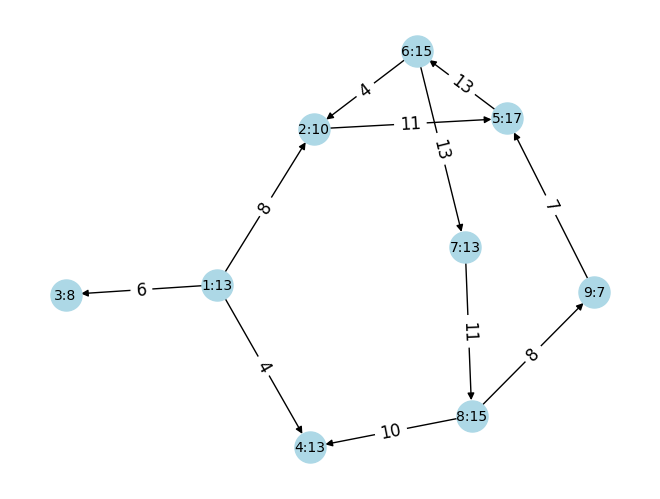

In [2]:
dataset = load_dataset("DeepPavlov/d2g_generated_augmented", token=True)
example = dataset['train'][0]
graph = Graph(example['graph'])
augmented_dialogs = [Dialog.from_list(**aug_dia) for aug_dia in example['augmented_dialogs']]
print(len(augmented_dialogs))
graph.visualise_short('')

# Functions

In [23]:
def dialogs_to_paths(graph, augmented_dialogs):
    # add id to each edge
    for edge in graph.graph_dict['edges']:
        edge_id = str(edge['source']) + '_' + str(edge['target'])
        edge['id'] = edge_id

    all_paths = []
    for i, aug_dia in enumerate(augmented_dialogs):
        path = {}
        path['nodes'] = []
        path['edges'] = []

        for turn in aug_dia.messages:
            if turn.participant == 'assistant':
                key = 'nodes'
            elif turn.participant == 'user':
                key = 'edges'

            for element in graph.graph_dict[key]:
                if turn.text in element['utterances']:
                    path[key].append(element['id'])

        path['nodes'] = set(path['nodes'])
        path['edges'] = set(path['edges'])

        all_paths.append((i, path))  

    return all_paths

def count_unique_elements(all_paths):
    num_unique_elements = []
    for i, path in all_paths:
        unique_elements = path['nodes'].union(path['edges'])
        num_unique_elements.append((i, len(unique_elements)))
    return num_unique_elements

def get_start_idx(num_unique_elements, all_paths):
    max_unique_elements = np.max([unique_elements for _, unique_elements in num_unique_elements])
    if max_unique_elements == 0:
        return (None, f'Error: no elements in the paths')
    
    idx_to_choose_from = []
    for i, unique_elements in num_unique_elements:
        if unique_elements == max_unique_elements:
            idx_to_choose_from.append(i)
    
    if len(idx_to_choose_from) == 1:
        start_idx = idx_to_choose_from[0]
    else:
        start_idx = int(np.random.choice(idx_to_choose_from))
    
    for i, path in all_paths:
        if i == start_idx:
            start_path = path
            
    return start_idx, start_path

def count_new_elements(path_1, path_2):
    new_nodes = set(path_2['nodes']).difference(set(path_1['nodes']))
    new_edges = set(path_2['edges']).difference(set(path_1['edges']))
    new_elements = len(new_nodes) + len(new_edges)
    return new_elements

def get_new_elements_per_path(all_paths, added_idx, combined_path):
    new_elements_per_path = []    

    for i, path in all_paths:
        if i in added_idx:
            continue
        else:
            new_elements = count_new_elements(combined_path, path)        
            new_elements_per_path.append((i, new_elements)) 
    
    return new_elements_per_path

def get_all_idx_and_paths_to_add(all_paths, added_idx, new_elements_per_path):
    if new_elements_per_path == []:
        return (None, f'no new elements in remaining dialogs')
    
    max_new_elements = np.max([new_elements for _, new_elements in new_elements_per_path])
    if max_new_elements == 0:
        return (None, f'no new elements in remaining dialogs')
    
    idx_to_choose_from = []
    for i, new_elements in new_elements_per_path:
        if i in added_idx:
            continue
        else:
            if new_elements == max_new_elements:
                idx_to_choose_from.append(i)
    
    paths_to_add = []
    for i, path in all_paths:
        if i in idx_to_choose_from:
            paths_to_add.append(path)
                
    return idx_to_choose_from, paths_to_add

def find_common_elements(combined_path, paths_to_add):
    # find all COMMON elements between combined_path and each path_to_add
    # make it a set to remove duplicates
    common_elements = []
    for path in paths_to_add:
        common_nodes = path['nodes'].intersection(combined_path['nodes'])
        common_edges = path['edges'].intersection(combined_path['edges'])
        common_elements += list(common_nodes.union(common_edges))
    common_elements = set(common_elements)
    
    return common_elements

def get_uttrs_for_common_elements(common_elements, graph):
    # collect all uttrs for each common_element (from the graph)
    common_elements_uttr = {}
    for el in common_elements:
        if isinstance(el, int):
            key = 'nodes'
        elif isinstance(el, str):
            key = 'edges'
        
        for graph_el in graph.graph_dict[key]:
            if graph_el['id'] == el:
                common_elements_uttr[el] = {'utterances' : set(graph_el['utterances'])}
                
    return common_elements_uttr

def find_golden_uttr(common_elements_uttr, added_idx, augmented_dialogs):
    # find golden uttr
    for el in common_elements_uttr:
        if isinstance(el, int):
            key = 'assistant'
        elif isinstance(el, str):
            key = 'user'
        
        common_elements_uttr[el]['golden_uttr'] = []
        
        for idx in added_idx:
            for turn in augmented_dialogs[idx].messages:
                if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                    common_elements_uttr[el]['golden_uttr'].append(turn.text)
        
    return common_elements_uttr

def get_uttrs_for_comparison(common_elements_uttr, idx_to_choose_from, augmented_dialogs):
    # collect uttr_for_comparison
    for el in common_elements_uttr:
        if isinstance(el, int):
            key = 'assistant'
        elif isinstance(el, str):
            key = 'user'
        
        uttr_for_comparison = []
        for idx in idx_to_choose_from:
            for turn in augmented_dialogs[idx].messages:
                if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                    uttr_for_comparison.append([idx, turn.text])

        common_elements_uttr[el]['uttr_for_comparison'] = uttr_for_comparison
        common_elements_uttr[el].pop('utterances')

    return common_elements_uttr

def get_uttr_similarity(common_elements_uttr):
    for el in common_elements_uttr:
        golden = common_elements_uttr[el]['golden_uttr']
        generated = [uttr for _, uttr in common_elements_uttr[el]['uttr_for_comparison']]
        similarities = get_similarity(golden=golden, generated=generated)

        for data, sim in zip(common_elements_uttr[el]['uttr_for_comparison'], similarities):
            data.append(sim[0])

    return common_elements_uttr

def get_dialog_similarity(common_elements_uttr, idx_to_choose_from):
    dialog_similarities = []
    for i in idx_to_choose_from:
        sum_sim = 0
        for el in common_elements_uttr:
            for id, _, sim in common_elements_uttr[el]['uttr_for_comparison']:
                if id == i:
                    sum_sim += sim
        dialog_similarities.append((i, sum_sim))
        dialog_similarities = sorted(dialog_similarities, key=lambda sim: sim[1])
    
    return dialog_similarities

def get_idx_and_path_to_add(dialog_similarities, all_paths):
    idx_to_add = dialog_similarities[0][0]
    for idx, path in all_paths:
        if idx == idx_to_add:
            path_to_add = path

    return idx_to_add, path_to_add

def add_new_elements_to_combined_path(combined_path, new_elements):
    combined_path['nodes'] = combined_path['nodes'].union(new_elements['nodes'])
    combined_path['edges'] = combined_path['edges'].union(new_elements['edges'])
    return combined_path

def remove_dialogs_with_same_path(all_paths, added_idx, path_to_compare_with):
    idx_to_remove = []
    for i, path in all_paths:
        if i in added_idx:
            continue
        else:
            if path == path_to_compare_with:
                idx_to_remove.append(i)
    
    while len(idx_to_remove) > 0:
        for i, path in all_paths:
            if i in idx_to_remove:
                all_paths.remove((i, path))
                
                idx_to_remove.remove(i)
    return all_paths

In [27]:
def get_minimal_needed_dialogs(graph, augmented_dialogs):
    all_paths = dialogs_to_paths(graph, augmented_dialogs)
    num_unique_elements = count_unique_elements(all_paths)
    start_idx, start_path = get_start_idx(num_unique_elements, all_paths)

    added_idx = []
    added_idx.append(start_idx)
    combined_path = start_path.copy()
    all_paths = remove_dialogs_with_same_path(all_paths, added_idx, start_path)
    print(f'Start dialog {start_idx} was added.') 
    
    for i in range(len(augmented_dialogs)):
        new_elements_per_path = get_new_elements_per_path(all_paths, added_idx, combined_path)
        idx_to_choose_from, paths_to_add = get_all_idx_and_paths_to_add(all_paths, added_idx, new_elements_per_path)
        if paths_to_add == 'no new elements in remaining dialogs':
            print(f'Iteration {i} - {paths_to_add}.')
            break

        common_elements = find_common_elements(combined_path, paths_to_add)
        common_elements_uttr = get_uttrs_for_common_elements(common_elements, graph)
        common_elements_uttr = find_golden_uttr(common_elements_uttr, added_idx, augmented_dialogs)
        common_elements_uttr = get_uttrs_for_comparison(common_elements_uttr, idx_to_choose_from, augmented_dialogs)
        common_elements_uttr = get_uttr_similarity(common_elements_uttr)

        dialog_similarities = get_dialog_similarity(common_elements_uttr, idx_to_choose_from)
        idx_to_add, path_to_add = get_idx_and_path_to_add(dialog_similarities, all_paths)

        if path_to_add == 'no new elements in remaining dialogs':
            print(f'Iteration {i} - {path_to_add}.')
            break
        else: 
            added_idx.append(idx_to_add)
            combined_path = add_new_elements_to_combined_path(combined_path, path_to_add)
            all_paths = remove_dialogs_with_same_path(all_paths, added_idx, path_to_add)
            print(f'Iteration {i} - dialog {idx_to_add} was added.')

    new_augmented_dialogs = []
    for idx in added_idx:
        new_augmented_dialogs.append(augmented_dialogs[idx])

    return new_augmented_dialogs

In [28]:
new_augmented_dialogs = get_minimal_needed_dialogs(graph, augmented_dialogs)
new_augmented_dialogs

Start dialog 1 was added.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration 0 - dialog 9 was added.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration 1 - dialog 16 was added.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration 2 - dialog 8 was added.
Iteration 3 - no new elements in remaining dialogs.


[Dialog(messages=[DialogMessage(text='Hey there! What assistance do you need today?', participant='assistant'), DialogMessage(text='I want to make an order.', participant='user'), DialogMessage(text='Sounds good! What item do you want to order?', participant='assistant'), DialogMessage(text="I'm interested in a t-shirt.", participant='user'), DialogMessage(text='Which size would you like?', participant='assistant'), DialogMessage(text='Medium would be great, thanks.', participant='user'), DialogMessage(text='Would you prefer it in red or blue?', participant='assistant'), DialogMessage(text='Red sounds good, thanks.', participant='user'), DialogMessage(text='Awesome! May I have your shipping address, please?', participant='assistant'), DialogMessage(text='Of course, my address is 123 Main St.', participant='user'), DialogMessage(text='Thank you! Your order is confirmed. Anything else I can assist you with?', participant='assistant'), DialogMessage(text='Can I change my order, please?', 